In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import copy
import matplotlib.pyplot as plt
from single_asset_strategies import *
from strategy_builder import *
from greeks_hedge_ratio import *

In [2]:
def relative_vol_mean_rev(df_merged, expiry, lookback, sd_multiple): 

    df_merged["IV_diff"] = df_merged[f"atm_vol_{expiry}_A"] - df_merged[f"atm_vol_{expiry}_B"]
    df_merged["IV_diff_MA"] = df_merged["IV_diff"].rolling(window=lookback).mean()
    df_merged["IV_diff_SD"] = df_merged["IV_diff"].rolling(window=lookback).std()

    for i in range(len(df_merged)-1):

        base_val_A = df_merged.loc[i, f"base_val_{expiry}_A"]
        base_val_B = df_merged.loc[i, f"base_val_{expiry}_B"]

        if (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"IV_diff"] > (df_merged.loc[i, "IV_diff_MA"] + sd_multiple * df_merged.loc[i, "IV_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": -10},
                                             {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": -10}]

            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": 10},
                                             {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": 10}]
            
        elif (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"IV_diff"] < (df_merged.loc[i, "IV_diff_MA"] - sd_multiple * df_merged.loc[i, "IV_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": 10},
                                             {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": 10}]

            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": -10},
                                             {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": -10}]
            
        else:
            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": 0}]
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": 0}]

    return df_merged

def relative_skew_mean_rev(df_merged, expiry, factor, sd, lookback, sd_multiple):

    df_merged["skew_diff"] = df_merged[f"skew_{factor}_{expiry}_A"] - df_merged[f"skew_{factor}_{expiry}_B"]
    df_merged["skew_diff_MA"] = df_merged["skew_diff"].rolling(window=lookback).mean()
    df_merged["skew_diff_SD"] = df_merged["skew_diff"].rolling(window=lookback).std()

    for i in range(len(df_merged)-1):

        base_val_A = df_merged.loc[i, f"base_val_{expiry}_A"]
        base_val_B = df_merged.loc[i, f"base_val_{expiry}_B"]
        dte_A = df_merged.loc[i, f"DTE_{expiry}_A"]
        dte_B = df_merged.loc[i, f"DTE_{expiry}_B"]
        atm_vol_A = df_merged.loc[i, f"atm_vol_{expiry}_A"]/100
        atm_vol_B = df_merged.loc[i, f"atm_vol_{expiry}_B"]/100

        delta_hedge_ratio_A = (get_greeks_ratio(base_val_A,atm_vol_A,sd)["call_delta_ratio"] + get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_delta_ratio"]) / 2
        delta_hedge_ratio_B = (get_greeks_ratio(base_val_B,atm_vol_B,sd)["call_delta_ratio"] + get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_delta_ratio"]) / 2

        if (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] > (df_merged.loc[i, "skew_diff_MA"] + sd_multiple * df_merged.loc[i, "skew_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "call", "size": -10},
                                             {"strike":base_val_A*(1-sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "put", "size": 10},
                                             {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_A*10}, # this is the delta hedging component
                                             {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_A*10}]

            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "call", "size": 10},
                                             {"strike":base_val_B*(1-sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "put", "size": -10},
                                             {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_B*10}, # this is the delta hedging component
                                             {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_B*10}]

            
        elif (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] < (df_merged.loc[i, "skew_diff_MA"] - sd_multiple * df_merged.loc[i, "skew_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "call", "size": 10},
                                             {"strike":base_val_A*(1-sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "put", "size": -10},
                                             {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_A*10}, # this is the delta hedging component
                                             {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_A*10}]

            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "call", "size": -10},
                                             {"strike":base_val_B*(1-sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "put", "size": 10},
                                             {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_B*10}, # this is the delta hedging component
                                             {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_B*10}]
            
        else:
            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": 0}]
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": 0}]

    return df_merged

def relative_upside_mean_rev(df_merged, expiry, factor, sd, lookback, sd_multiple): 

    df_merged["skew_diff"] = df_merged[f"skew_{factor}_{expiry}_A"] - df_merged[f"skew_{factor}_{expiry}_B"]
    df_merged["kurt_diff"] = df_merged[f"kurt_{factor}_{expiry}_A"] - df_merged[f"kurt_{factor}_{expiry}_B"]

    df_merged["skew_diff_MA"] = df_merged["skew_diff"].rolling(window=lookback).mean()
    df_merged["kurt_diff_MA"] = df_merged["kurt_diff"].rolling(window=lookback).mean()

    df_merged["skew_diff_SD"] = df_merged["skew_diff"].rolling(window=lookback).std()
    df_merged["kurt_diff_SD"] = df_merged["kurt_diff"].rolling(window=lookback).std()

    for i in range(len(df_merged)-1):

        base_val_A = df_merged.loc[i, f"base_val_{expiry}_A"]
        base_val_B = df_merged.loc[i, f"base_val_{expiry}_B"]
        dte_A = df_merged.loc[i, f"DTE_{expiry}_A"]
        dte_B = df_merged.loc[i, f"DTE_{expiry}_B"]
        atm_vol_A = df_merged.loc[i, f"atm_vol_{expiry}_A"]/100
        atm_vol_B = df_merged.loc[i, f"atm_vol_{expiry}_B"]/100

        delta_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_delta_ratio"]
        gamma_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_gamma_ratio"]

        delta_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_delta_ratio"]
        gamma_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_gamma_ratio"]

        if (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] < (df_merged.loc[i, "skew_diff_MA"] - sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] < (df_merged.loc[i, "kurt_diff_MA"] - sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "call", "size": 10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_A*10-gamma_hedge_ratio_A*5}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_A*10-gamma_hedge_ratio_A*5}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "call", "size": -10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_B*10+gamma_hedge_ratio_B*5}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_B*10+gamma_hedge_ratio_B*5}]


        elif (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] > (df_merged.loc[i, "skew_diff_MA"] + sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] > (df_merged.loc[i, "kurt_diff_MA"] + sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "call", "size": -10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_A*10+gamma_hedge_ratio_A*5}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_A*10+gamma_hedge_ratio_A*5}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "call", "size": 10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_B*10-gamma_hedge_ratio_B*5}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_B*10-gamma_hedge_ratio_B*5}]
            
        else:
            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": 0}]
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": 0}]

    return df_merged

def relative_downside_mean_rev(df_merged, expiry, factor, sd, lookback, sd_multiple): 

    df_merged["skew_diff"] = df_merged[f"skew_{factor}_{expiry}_A"] - df_merged[f"skew_{factor}_{expiry}_B"]
    df_merged["kurt_diff"] = df_merged[f"kurt_{factor}_{expiry}_A"] - df_merged[f"kurt_{factor}_{expiry}_B"]

    df_merged["skew_diff_MA"] = df_merged["skew_diff"].rolling(window=lookback).mean()
    df_merged["kurt_diff_MA"] = df_merged["kurt_diff"].rolling(window=lookback).mean()

    df_merged["skew_diff_SD"] = df_merged["skew_diff"].rolling(window=lookback).std()
    df_merged["kurt_diff_SD"] = df_merged["kurt_diff"].rolling(window=lookback).std()

    for i in range(len(df_merged)-1):

        base_val_A = df_merged.loc[i, f"base_val_{expiry}_A"]
        base_val_B = df_merged.loc[i, f"base_val_{expiry}_B"]
        dte_A = df_merged.loc[i, f"DTE_{expiry}_A"]
        dte_B = df_merged.loc[i, f"DTE_{expiry}_B"]
        atm_vol_A = df_merged.loc[i, f"atm_vol_{expiry}_A"]/100
        atm_vol_B = df_merged.loc[i, f"atm_vol_{expiry}_B"]/100

        delta_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_delta_ratio"]
        gamma_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_gamma_ratio"]

        delta_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_delta_ratio"]
        gamma_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_gamma_ratio"]

        if (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] > (df_merged.loc[i, "skew_diff_MA"] + sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] < (df_merged.loc[i, "kurt_diff_MA"] - sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "put", "size": 10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_A*10-gamma_hedge_ratio_A*5}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_A*10-gamma_hedge_ratio_A*5}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "put", "size": -10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_B*10+gamma_hedge_ratio_B*5}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_B*10+gamma_hedge_ratio_B*5}]


        elif (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] < (df_merged.loc[i, "skew_diff_MA"] - sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] > (df_merged.loc[i, "kurt_diff_MA"] + sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "put", "size": -10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_A*10+gamma_hedge_ratio_A*5}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_A*10+gamma_hedge_ratio_A*5}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "put", "size": 10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_B*10-gamma_hedge_ratio_B*5}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_B*10-gamma_hedge_ratio_B*5}]

        else:
            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": 0}]
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": 0}]

    return df_merged

def relative_upside_mean_rev_gu(df_merged, expiry, factor, sd, lookback, sd_multiple): 

    df_merged["skew_diff"] = df_merged[f"skew_{factor}_{expiry}_A"] - df_merged[f"skew_{factor}_{expiry}_B"]
    df_merged["kurt_diff"] = df_merged[f"kurt_{factor}_{expiry}_A"] - df_merged[f"kurt_{factor}_{expiry}_B"]

    df_merged["skew_diff_MA"] = df_merged["skew_diff"].rolling(window=lookback).mean()
    df_merged["kurt_diff_MA"] = df_merged["kurt_diff"].rolling(window=lookback).mean()

    df_merged["skew_diff_SD"] = df_merged["skew_diff"].rolling(window=lookback).std()
    df_merged["kurt_diff_SD"] = df_merged["kurt_diff"].rolling(window=lookback).std()

    for i in range(len(df_merged)-1):

        base_val_A = df_merged.loc[i, f"base_val_{expiry}_A"]
        base_val_B = df_merged.loc[i, f"base_val_{expiry}_B"]
        dte_A = df_merged.loc[i, f"DTE_{expiry}_A"]
        dte_B = df_merged.loc[i, f"DTE_{expiry}_B"]
        atm_vol_A = df_merged.loc[i, f"atm_vol_{expiry}_A"]/100
        atm_vol_B = df_merged.loc[i, f"atm_vol_{expiry}_B"]/100

        delta_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_delta_ratio"]
        gamma_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_gamma_ratio"]

        delta_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_delta_ratio"]
        gamma_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_gamma_ratio"]

        if (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] < (df_merged.loc[i, "skew_diff_MA"] - sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] < (df_merged.loc[i, "kurt_diff_MA"] - sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "call", "size": 10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_A*10}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_A*10}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "call", "size": -10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_B*10}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_B*10}]


        elif (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] > (df_merged.loc[i, "skew_diff_MA"] + sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] > (df_merged.loc[i, "kurt_diff_MA"] + sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "call", "size": -10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_A*10}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_A*10}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "call", "size": 10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_B*10}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_B*10}]
            
        else:
            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": 0}]
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": 0}]

    return df_merged

def relative_downside_mean_rev_gu(df_merged, expiry, factor, sd, lookback, sd_multiple): 

    df_merged["skew_diff"] = df_merged[f"skew_{factor}_{expiry}_A"] - df_merged[f"skew_{factor}_{expiry}_B"]
    df_merged["kurt_diff"] = df_merged[f"kurt_{factor}_{expiry}_A"] - df_merged[f"kurt_{factor}_{expiry}_B"]

    df_merged["skew_diff_MA"] = df_merged["skew_diff"].rolling(window=lookback).mean()
    df_merged["kurt_diff_MA"] = df_merged["kurt_diff"].rolling(window=lookback).mean()

    df_merged["skew_diff_SD"] = df_merged["skew_diff"].rolling(window=lookback).std()
    df_merged["kurt_diff_SD"] = df_merged["kurt_diff"].rolling(window=lookback).std()

    for i in range(len(df_merged)-1):

        base_val_A = df_merged.loc[i, f"base_val_{expiry}_A"]
        base_val_B = df_merged.loc[i, f"base_val_{expiry}_B"]
        dte_A = df_merged.loc[i, f"DTE_{expiry}_A"]
        dte_B = df_merged.loc[i, f"DTE_{expiry}_B"]
        atm_vol_A = df_merged.loc[i, f"atm_vol_{expiry}_A"]/100
        atm_vol_B = df_merged.loc[i, f"atm_vol_{expiry}_B"]/100

        delta_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_delta_ratio"]
        gamma_hedge_ratio_A = get_greeks_ratio(base_val_A,atm_vol_A,sd)["put_gamma_ratio"]

        delta_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_delta_ratio"]
        gamma_hedge_ratio_B = get_greeks_ratio(base_val_B,atm_vol_B,sd)["put_gamma_ratio"]

        if (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] > (df_merged.loc[i, "skew_diff_MA"] + sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] < (df_merged.loc[i, "kurt_diff_MA"] - sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "put", "size": 10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_A*10}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_A*10}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "put", "size": -10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_B*10}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_B*10}]


        elif (df_merged.loc[i, "expiry_date_1_A"] == df_merged.loc[i+1, "expiry_date_1_A"]
            and df_merged.loc[i, "expiry_date_1_B"] == df_merged.loc[i+1, "expiry_date_1_B"]

            and df_merged.loc[i, f"skew_diff"] < (df_merged.loc[i, "skew_diff_MA"] - sd_multiple * df_merged.loc[i, "skew_diff_SD"])
            and df_merged.loc[i, f"kurt_diff"] > (df_merged.loc[i, "kurt_diff_MA"] + sd_multiple * df_merged.loc[i, "kurt_diff_SD"])

            and df_merged.loc[i+1, "base_change_1_A"] > -0.45
            and df_merged.loc[i+1, "base_change_1_B"] > -0.45):

            df_merged.at[i,"positions_A"] = [{"strike":base_val_A*(1+sd*atm_vol_A*((dte_A/365)**0.5)), "expiry": expiry, "option_type": "put", "size": -10},

                                    {"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": -delta_hedge_ratio_A*10}, # this is the delta hedging component
                                    {"strike":base_val_A, "expiry": expiry, "option_type": "put", "size": delta_hedge_ratio_A*10}]
            
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B*(1+sd*atm_vol_B*((dte_B/365)**0.5)), "expiry": expiry, "option_type": "put", "size": 10},

                                    {"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": delta_hedge_ratio_B*10}, # this is the delta hedging component
                                    {"strike":base_val_B, "expiry": expiry, "option_type": "put", "size": -delta_hedge_ratio_B*10}]

        else:
            df_merged.at[i,"positions_A"] = [{"strike":base_val_A, "expiry": expiry, "option_type": "call", "size": 0}]
            df_merged.at[i,"positions_B"] = [{"strike":base_val_B, "expiry": expiry, "option_type": "call", "size": 0}]

    return df_merged

In [3]:
df_1 = generate_polynomial("RUT")
df_2 = generate_polynomial("SPX")
df_merged = merge_dataframes(df_1, df_2)

# df_merged = relative_vol_mean_rev(df_merged, 2, 30, 10)
# df_merged = relative_skew_mean_rev(df_merged, 1, 1, 1, 30, 0.5)
df_merged = relative_downside_mean_rev(df_merged, 2, 1, 1, 30, 0)

df1, df2 = split_dataframe(df_merged, date_col="date", suffix1="_A", suffix2="_B")
df_pnl_1 = calculate_pnl(df1)
df_pnl_2 = calculate_pnl(df2)

c:\Users\RyanTan\OneDrive - Sebrina Holdings Pte Ltd\Desktop\backtest_engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '184.70475087036345' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "PnL"] = pnl
c:\Users\RyanTan\OneDrive - Sebrina Holdings Pte Ltd\Desktop\backtest_engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-214.00478237026425' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "PnL"] = pnl


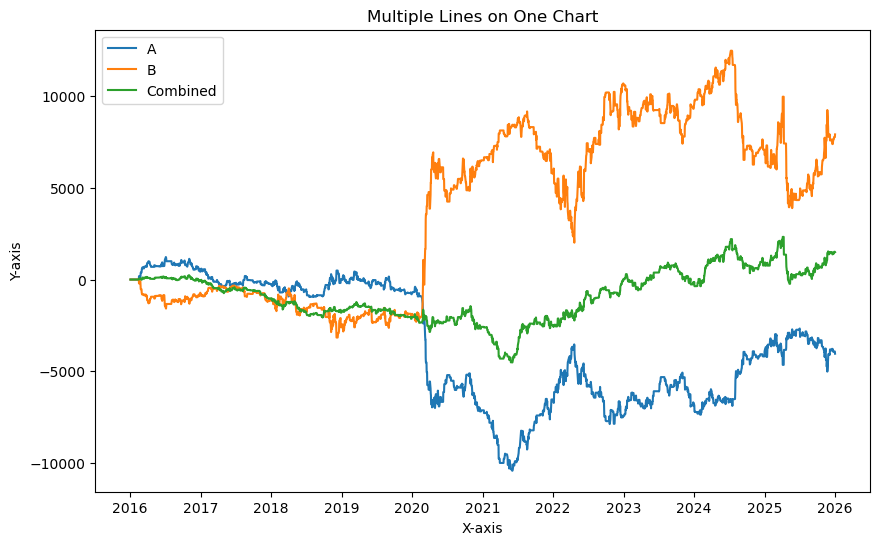

In [4]:
# Plot multiple lines
plt.figure(figsize=(10, 6))
plt.plot(df_pnl_1["date"], df_pnl_1["Cumulative PnL"], label='A')
plt.plot(df_pnl_2["date"], df_pnl_2["Cumulative PnL"], label='B')
plt.plot(df_pnl_1["date"], df_pnl_1["Cumulative PnL"] + 0.7 * df_pnl_2["Cumulative PnL"], label='Combined')

# Add labels, title, and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Multiple Lines on One Chart")
plt.legend()

# Show the plot
plt.show()